In [3]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd 
import torch as torch 
import torch.nn as nn
import torch.optim as optim
import dataset_utils
import torch.nn.functional as F
import torchvision.models as models
from pytorch_metric_learning import distances, losses, miners, reducers

In [23]:

def binarize_hard(x):
    y = torch.where(x > 0, 1.0, -1.0)
    return y

In [5]:
class BinaryModel(nn.Module):
    def __init__(self, dim, D, num_classes, enc_type='RP', binary=True, device='cpu', kargs=None):
        super(BinaryModel, self).__init__()
        self.enc_type, self.binary = enc_type, binary	
        self.device = device
        if enc_type in ['RP', 'RP-COS']:
            self.rp_layer = nn.Linear(dim, D).to(device)
            self.class_hvs = torch.zeros(num_classes, D).float().to(device)
            self.class_hvs_nb = torch.zeros(num_classes, D).float().to(device)
        else:
            pass
    #hard sigmoid    
    def weight_binarize(self, W):
       W = torch.where(W<-1,-1,W)
       W = torch.where(W>1,1,W)
       mask1 = (W >= -1) & (W < 0)
       W[mask1] = 2 * W[mask1] + W[mask1]*W[mask1]
       mask2 = (W >= 0) & (W < 1)
       W[mask2] = 2 * W[mask2] - W[mask2]*W[mask2]
       # W[W > 1] = 1
       return W
    #using Bi-Real Approximation     
    def activation_binarize(self,a):
       a = torch.where(a<-1,-1,a)
       a = torch.where(a>1,1,a)
       mask1 = (a >= -1) & (a < 0)
       a[mask1] = 2 * a[mask1] + a[mask1]*a[mask1]
       #a[mask1] = 0
       mask2 = (a >= 0) & (a < 1)
       a[mask2] = 2 * a[mask2] - a[mask2]*a[mask2]
       #a = torch.where((a >= -1) & (a < 0),2*a + torch.pow(a,2) )
       #a = torch.where((a >= 0) & (a < 1), 2*a- torch.pow(a,2))
    #    a [a < -1] = -1
    #    a [a > 1]   =  1
    #    a [(a >= -1) & (a < 0)] = 2*a[(a >= -1) & (a < 0)] + torch.pow(a [(a >= -1) & (a < 0)],2)
    #    a [(a >= 0) & (a < 1)] = 2*a[(a >= 0) & (a < 1)] - torch.pow(a [(a >= 0) & (a < 1)],2)
       return a

    def encoding(self, x):
        if self.enc_type == 'RP':
            #x = self.activation_binarize(x) 
            #need not binarize the inputs 
            #progressively binarize the inputs, after training the weights
            #add some print statements and check 
            #print("The value of weights, before binarization")
            #print(self.rp_layer.weight.data)
            weights = self.rp_layer.weight.data.clone()
            weights_bin = self.weight_binarize(weights)
            self.rp_layer.weight.data = weights_bin.clone() 
            out = self.rp_layer(x)
            #print("The value of weights, after binarization")
            #print(self.rp_layer.weight.data)
        else:
                pass
        
        return self.activation_binarize(out) if self.binary else out
    
    #Forward Function
    def forward(self, x, embedding=False):
        out = self.encoding(x)
        if embedding:
            out = out
        else:
            out = self.similarity(class_hvs=binarize_hard(self.class_hvs), enc_hv=out)   
        return out
    
    def init_class(self, x_train, labels_train):
        out = self.encoding(x_train)
        for i in range(x_train.size()[0]):
            self.class_hvs[labels_train[i]] += out[i]

        self.class_hvs = binarize_hard(self.class_hvs)
        
    def HD_train_step(self, x_train, y_train, lr=1.0):
        shuffle_idx = torch.randperm(x_train.size()[0])
        x_train = x_train[shuffle_idx]
        train_labels = y_train[shuffle_idx]
        l= list(self.rp_layer.parameters())
        enc_hvs = binarize_hard(self.encoding(x_train))
        for i in range(enc_hvs.size()[0]):
            sims = self.similarity(self.class_hvs, enc_hvs[i].unsqueeze(dim=0))
            predict = torch.argmax(sims, dim=1)
            
            if predict != train_labels[i]:
                self.class_hvs_nb[predict] -= lr * enc_hvs[i]
                self.class_hvs_nb[train_labels[i]] += lr * enc_hvs[i]
            
            self.class_hvs.data = binarize_hard(self.class_hvs_nb)
    
    def similarity(self, class_hvs, enc_hv):
	    return torch.matmul(enc_hv, class_hvs.t())/class_hvs.size()[1]
    
    

In [6]:
nFeatures, nClasses, x_train, y_train, x_test, y_test, train_loader, test_loader\
        = dataset_utils.load_dataset('mnist', 256, "cpu")


In [7]:

model = BinaryModel(dim = nFeatures, D=1000, num_classes=nClasses, enc_type='RP', device="cpu")

In [8]:
lr = 0.001
distance = distances.CosineSimilarity()
reducer = reducers.ThresholdReducer(low=0.0)


In [9]:

def HD_test(model, x_test, y_test):
    out = model(x_test, embedding=False)
    preds = torch.argmax(out, dim=-1)

    acc = torch.mean((preds==y_test).float())	
    return acc

def get_Hamming_margin(model, x_test, y_test=None):
	def Hamming_distance(a, b):
		D = a.size()[1]
		return (D - a @ b.T)/2

	# Compute mean Hamming distance between class HVS
	class_hvs = binarize_hard(model.class_hvs.data)
	class_Hamming_distance = Hamming_distance(class_hvs, class_hvs)
	mean_class_Hamming_distance = torch.mean(class_Hamming_distance).item()
	

	# Compute test samples' Hamming distance
	test_enc_hvs = binarize_hard(model(x_test, True)) 
	test_Hamming_dist = Hamming_distance(test_enc_hvs, class_hvs)

	sorted_test_Hamming_distance, _ = torch.sort(test_Hamming_dist, dim=-1, descending=False)
	test_enc_hvs_Hamming_margin = (sorted_test_Hamming_distance[:,1:]-sorted_test_Hamming_distance[:,0].unsqueeze(dim=1)).mean(dim=1).cpu()
	mean_test_Hamming_margin = torch.mean(test_enc_hvs_Hamming_margin).item()

	res_dict = {
		"avg_class_Hamming_dist": mean_class_Hamming_distance,
		"avg_test_Hamming_margin": mean_test_Hamming_margin
	}
	return mean_test_Hamming_margin

In [10]:

num_metric_epochs = 2
device = "cpu"
accuracies = []
accuracies.append(HD_test(model, x_test, y_test).item())
margins = []
margins.append(get_Hamming_margin(model, x_test, y_test))

In [11]:
loss_func = losses.TripletMarginLoss(margin=0.2, distance=distance, reducer=reducer)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0) 

In [12]:
model.class_hvs = nn.parameter.Parameter(data=model.class_hvs)
mining_func = miners.TripletMarginMiner(
    margin=0.2, distance=distance, type_of_triplets="semihard", )

In [13]:
def metric_train(model, loss_func, mining_func, device, train_loader, optimizer, epoch,segment_length, zeroes):
    model.train()
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        embeddings = model(data.reshape(data.size()[0],-1))
        indices_tuple = mining_func(embeddings, labels)
        loss = loss_func(embeddings,labels,indices_tuple)
        #loss = CustomLoss(model, distance = distance,reducer = reducer,dimension = 1000, segment_size = 100, sparsity_factor= 20, penalty_factor = 0.1)
        loss.backward()
        optimizer.step()
    

In [14]:
### pytorch-metric-learning using Triplet margin loss ###
print("Triplet Loss")
for epoch_i in range(1, num_metric_epochs + 1):
    metric_train(model, loss_func, mining_func, device, train_loader, optimizer, epoch_i,segment_length=50, zeroes=25)
    accuracies.append(HD_test(model, x_test, y_test).item())
    margins.append(get_Hamming_margin(model, x_test, y_test))
    print("Epoch",epoch_i)


Triplet Loss
Epoch 1
Epoch 2


In [21]:
import torch
weights_updated = torch.zeros(model.rp_layer.weight.size())
weights_updated = model.rp_layer.weight.data.clone()   
print(torch.equal(weights_updated,model.rp_layer.weight.data))

True


In [35]:
 
print(weights_updated)
weight_bin= binarize_hard(weights_updated)
#print(weight_bin)
#histogram = torch.histc(weight_bin, bins=5, min=-1, max=1)
#condition = (weight_bin != -1) & (weight_bin != 1)
#print(condition)
print(torch.any((weight_bin != -1.0) & (weight_bin != 1.0)))
#plt.hist(histogram, bins=5, range=(-1, 1))
#w = torch.nn.Parameter(torch.randn(1,10))
#print(w)
#w = binarize_hard(w)
#print(w)

tensor([[ 1., -1.,  1.,  ...,  1.,  1.,  1.],
        [-1.,  1.,  1.,  ..., -1.,  1.,  1.],
        [ 1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [ 1., -1., -1.,  ...,  1., -1., -1.],
        [ 1., -1., -1.,  ..., -1.,  1., -1.],
        [-1.,  1.,  1.,  ..., -1.,  1.,  1.]])
tensor(False)


In [37]:

#make the binarize function bipolar
model.rp_layer.weight.data  = weight_bin.clone()
print("Trained Weights")
print(torch.any((model.rp_layer.weight.data != -1.0) & (model.rp_layer.weight.data != 1.0)))


Trained Weights
tensor(False)


In [38]:
HD_lr = 0.05
num_HD_epoch = 20

In [39]:
class_accuracies = []
class_margins = []
for epoch_i in range(1, num_HD_epoch+1):
    model.HD_train_step(x_train, y_train, lr=HD_lr)
    print("Accuracy",HD_test(model, x_test, y_test).item())
    class_accuracies.append(HD_test(model, x_test, y_test).item())
    print("Class accuracy", class_accuracies[epoch_i-1])
    class_margins.append(get_Hamming_margin(model, x_test, y_test))
    print("Epoch",epoch_i)
    

Accuracy 0.8788999915122986
Class accuracy 0.8788999915122986
Epoch 1
Accuracy 0.8964999914169312
Class accuracy 0.8964999914169312
Epoch 2
Accuracy 0.8794999718666077
Class accuracy 0.8794999718666077
Epoch 3
Accuracy 0.8837000131607056
Class accuracy 0.8837000131607056
Epoch 4
Accuracy 0.8955000042915344
Class accuracy 0.8955000042915344
Epoch 5
Accuracy 0.892799973487854
Class accuracy 0.892799973487854
Epoch 6
Accuracy 0.8906000256538391
Class accuracy 0.8906000256538391
Epoch 7
Accuracy 0.8762000203132629
Class accuracy 0.8762000203132629
Epoch 8
Accuracy 0.8819000124931335
Class accuracy 0.8819000124931335
Epoch 9
Accuracy 0.8952999711036682
Class accuracy 0.8952999711036682
Epoch 10
Accuracy 0.8849999904632568
Class accuracy 0.8849999904632568
Epoch 11
Accuracy 0.9000999927520752
Class accuracy 0.9000999927520752
Epoch 12
Accuracy 0.8744999766349792
Class accuracy 0.8744999766349792
Epoch 13
Accuracy 0.8830999732017517
Class accuracy 0.8830999732017517
Epoch 14
Accuracy 0.893100

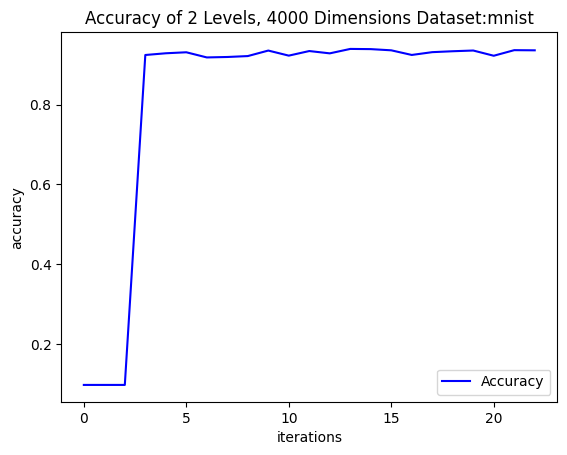

Maximum Accuracy:0.9391999840736389


In [42]:
plt.plot(accuracies, label="Accuracy", c = "blue")
plt.xlabel("iterations")
plt.ylabel("accuracy")
plt.title("Accuracy of 2 Levels, 4000 Dimensions Dataset:mnist")
plt.legend()
plt.show()
print("Maximum Accuracy:{}".format(max(accuracies)))